<h1> ELO Merchant Category Recommendation </h1>
<h3> Help understand customer loyalty </h3>

Earlier this year ELO, one of the largest payment brands in Brazil, put out a competition to identify customer loyalty signals. The dataset consists largely of past customer transactions and other tabular features. All of these were contained in the following data files:

**train.csv** Tabular features and loyalty scores for a set of card_ids.

**test.csv** Same as test without loyalty scores for different card_ids.

**historical_transactions.csv:** ~1GB of past customer transactions with at least three months of data for every cardid in the data set.

**new_merchant_transactions.csv** ~20mb of data for two months worth of purchases made at merchant_ids that were not visited in the historical dataset.

## Loading Data and EDA

In [275]:
# Basic Packages
import pandas as pd
import numpy as np
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

# ML Packages
import lightgbm as lgb
from sklearn import model_selection, preprocessing, metrics

# plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Train and Test Sets

In [43]:
dtypes = {'feature_1':'int16',
          'feature_2':'int16',
          'feature_3':'int16'
         }

train_df = pd.read_csv("train.csv",dtype=dtypes,parse_dates=['first_active_month'])
test_df = pd.read_csv("test.csv",dtype=dtypes,parse_dates=['first_active_month'])

print(f"Training Set Shape:{train_df.shape}")
display(train_df.head())
print(f"Test Set Shape:{test_df.shape}")
display(test_df.head())

Training Set Shape:(201917, 6)


,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749


Test Set Shape:(123623, 5)


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1


In [44]:
test_df.isna().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [45]:
for df in [train_df,test_df]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime.today() - df['first_active_month']).dt.days

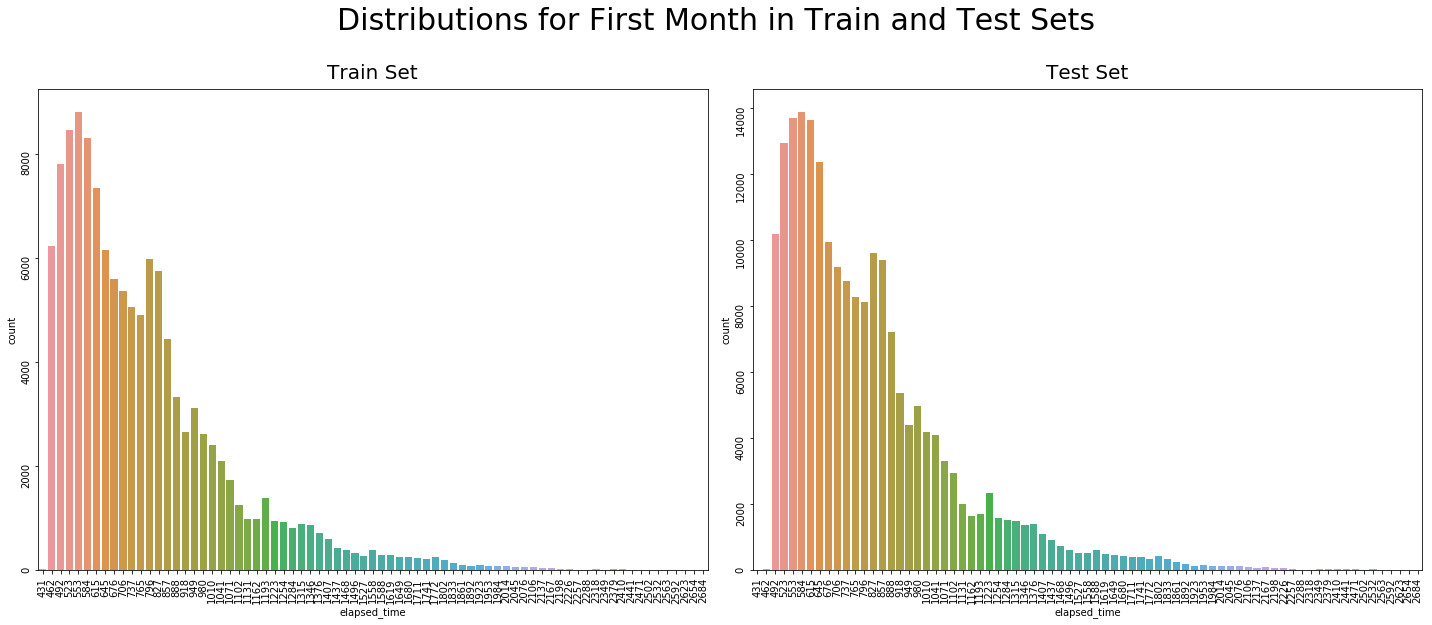

In [82]:
f,axes = plt.subplots(1,2,figsize = (20,8),sharex=True)
axes = axes.ravel()

sns.countplot(train_df['elapsed_time'],ax = axes[1])
axes[0].tick_params(labelrotation=90)
axes[0].set_title('Train Set',size=20,y=1.01)

sns.countplot(test_df['elapsed_time'].dropna().astype('int16'),ax = axes[0])
axes[1].tick_params(labelrotation=90)
axes[1].set_title('Test Set',size = 20,y=1.01)

plt.suptitle('Distributions for First Month in Train and Test Sets',size = 30,y=1.08)
plt.tight_layout()

The train and test set appear to be very similar in terms of what date the card_ids started. Now lets look at how the target variables are distributed.

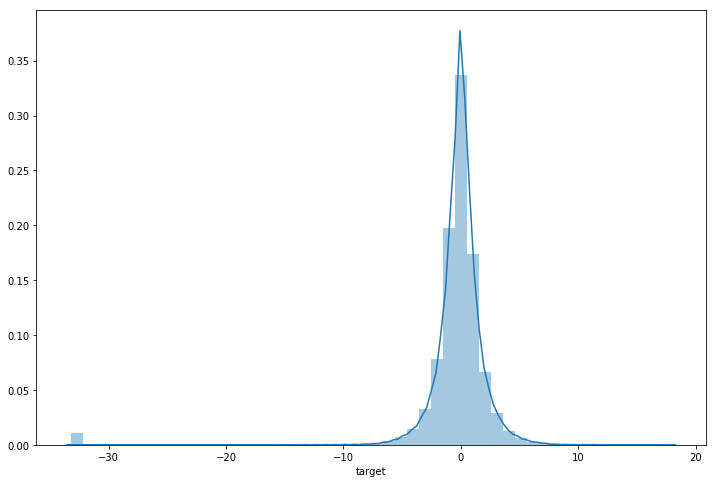

In [70]:
plt.figure(figsize = (12,8))
sns.distplot(train_df['target'])

Most of the data is distributed between -10 and 10, but there are a few outliers located past -30. These will likely play a huge role in the performance of our model as they will greatly affect metrics such as RMSE. Now lets check how the target changes with respect to each "feature" included in the test set.

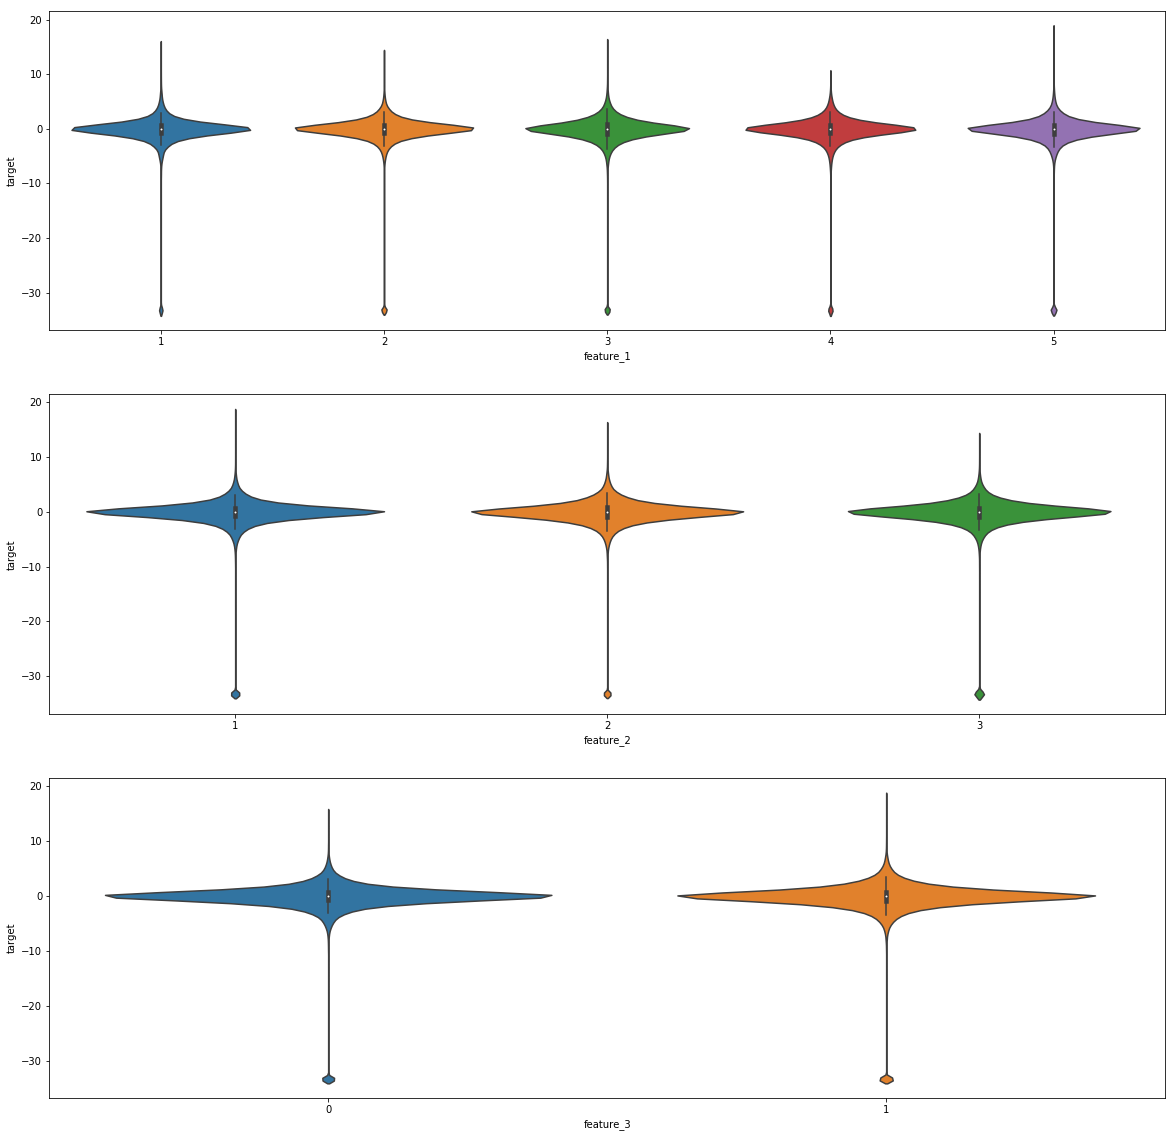

In [86]:
f,axes = plt.subplots(3,1,figsize = (20,20))
axes = axes.ravel()
sns.violinplot(x='feature_1',y='target',data=train_df,ax = axes[0])
sns.violinplot(x='feature_2',y='target',data=train_df,ax = axes[1])
sns.violinplot(x='feature_3',y='target',data=train_df,ax = axes[2])

The "features" dont appear to tell us much about the target variable as each distribution is more or less constant. Lets check if any particular feature interactions might have different distributions.

In [97]:
for df in [train_df,test_df]:
    df['feature_1_2'] = df['feature_1'].map(str)+df['feature_2'].map(str)
    df['feature_1_3'] = df['feature_1'].map(str)+df['feature_3'].map(str)
    df['feature_2_3'] = df['feature_2'].map(str)+df['feature_3'].map(str)
    df['feature_1_2_3'] = df['feature_1'].map(str)+df['feature_2'].map(str)+df['feature_3'].map(str)

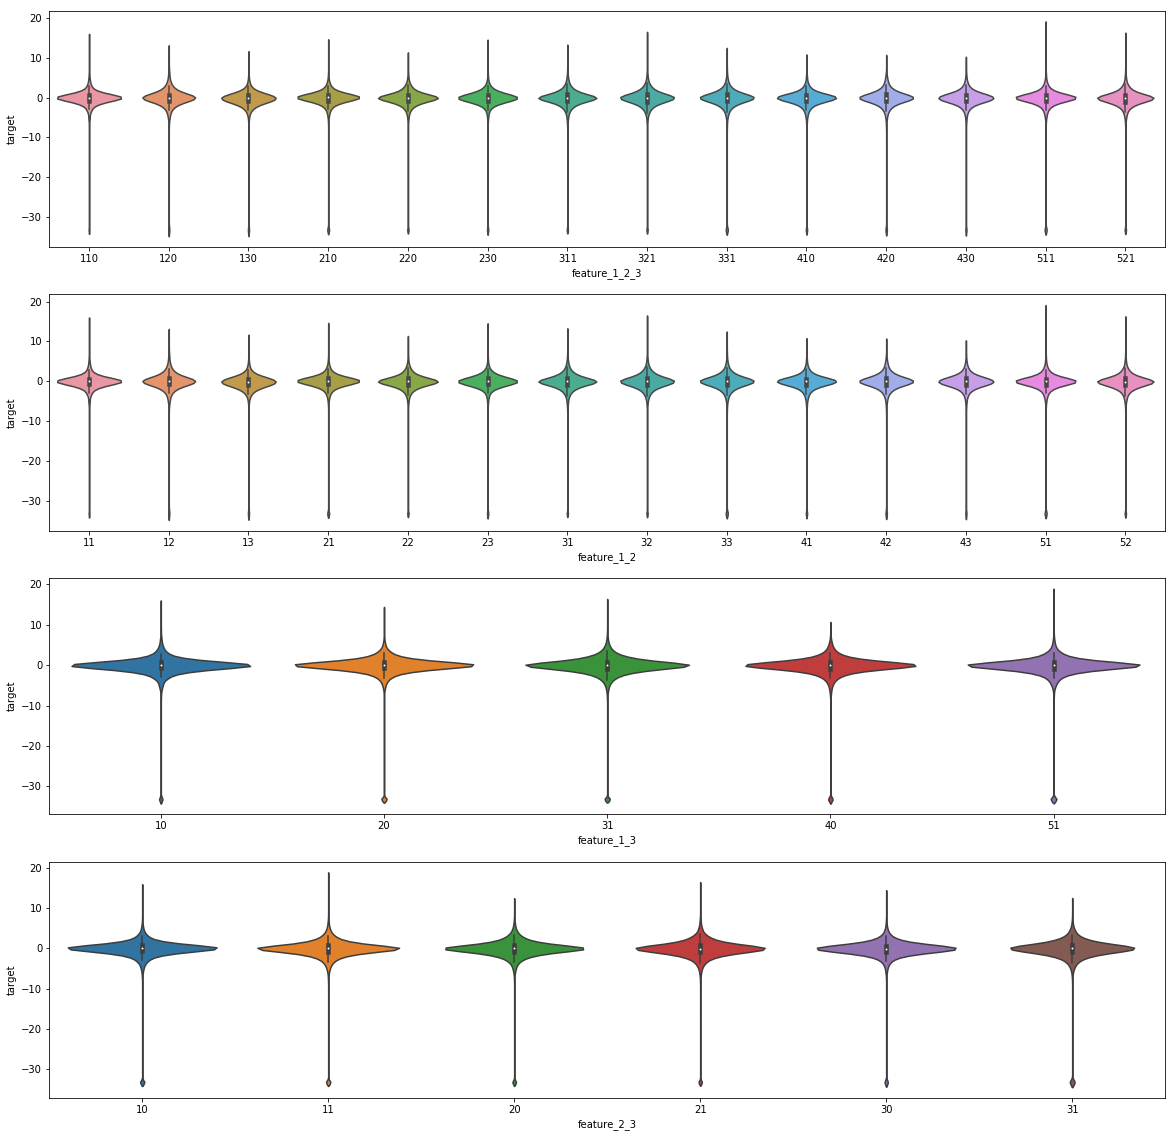

In [102]:
f,axes = plt.subplots(4,1,figsize = (20,20))
axes = axes.ravel()
sns.violinplot(x='feature_1_2_3',y='target',data=train_df,ax = axes[0])
sns.violinplot(x='feature_1_2',y='target',data=train_df,ax = axes[1])
sns.violinplot(x='feature_1_3',y='target',data=train_df,ax = axes[2])
sns.violinplot(x='feature_2_3',y='target',data=train_df,ax = axes[3])

Okay so it seems pretty apparent that the "features" may not be the most helpful as its hard to identify a single combination that has a meaningfully different distribution. Lets drop the new columns and move on to the new merchant file.

In [280]:
for df in [train_df,test_df]:
    df.drop(columns = ['feature_1_2','feature_1_3','feature_2_3','feature_1_2_3'],inplace=True)

### New Merchant Transactions

In [145]:
# Here we can specify the data types to reduce memory usage by ~50%
data_types = {'authorized_flag':'str',
                   'card_id':'str',
                   'city_id':'int16',
                   'installments':'int16',
                   'category_3':'str',
                   'merchant_category_id':'int16',
                   'merchant_id':'str',
                   'purchase_amount':'float',
                   'state_id':'int16',
                   'subsector_id':'int16'}

new_trans_df = pd.read_csv('new_merchant_transactions.csv',dtype=data_types,parse_dates=True)

In [146]:
print('New Merchant Transactions DataFrame Shape:',new_trans_df.shape)
new_trans_df.head()

New Merchant Transactions DataFrame Shape: (1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


lets start with the numeric columns as those are generally the most straightforward, namely:

- installments
- purchase_amount
- month_lag

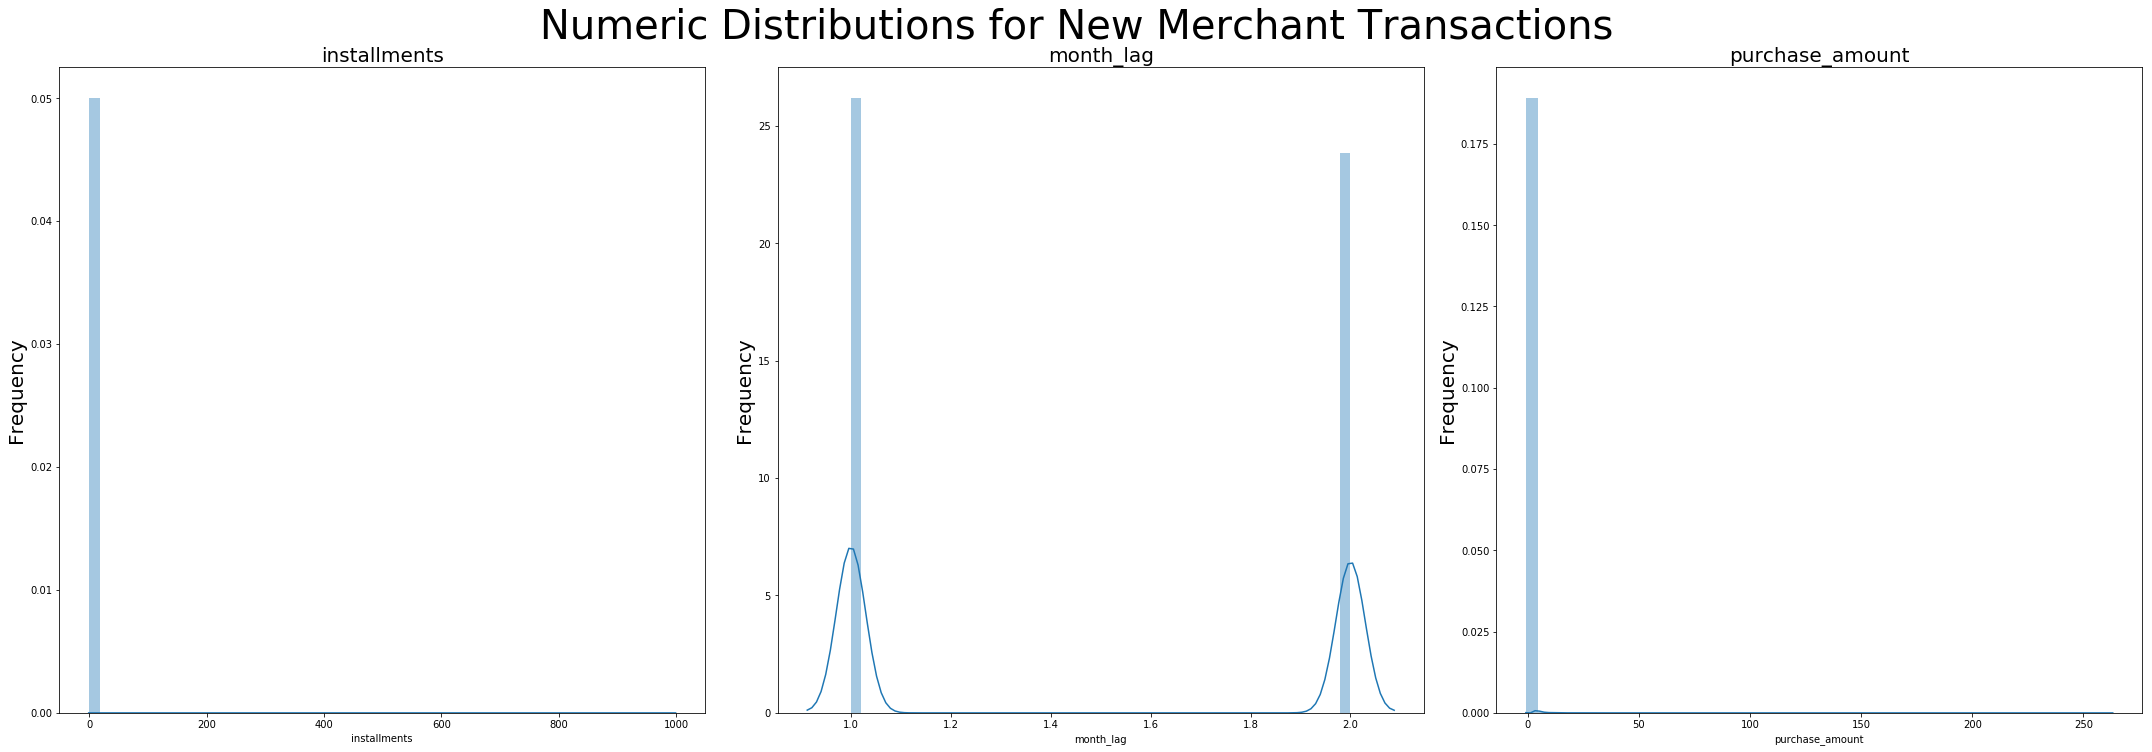

In [147]:
numeric_cols = ['installments','month_lag','purchase_amount']

f,axes = plt.subplots(1,3,figsize=(30,10))
axes = axes.ravel()

for i,col in enumerate(numeric_cols):
    sns.distplot(new_trans_df[col].dropna(),ax=axes[i])
    axes[i].set_title(col,size=20)
    axes[i].set_ylabel('Frequency',size=20)
    axes[i].tick_params(axis='y', labelsize=10)
plt.suptitle("Numeric Distributions for New Merchant Transactions",size=40,y=1.04)
plt.tight_layout()
plt.show()

The for installments we see a maximum value around 1000 which might indicate some values were filled with 999 (a common thing to fill when data is missing). Purchase amount is likely skewed as it is something we could reasonably expect to span several orders of magnitude. The month_lag column only has two unique values. Lets set an upper bound for these columns to see if we can get a better look at the distributions.

12.0


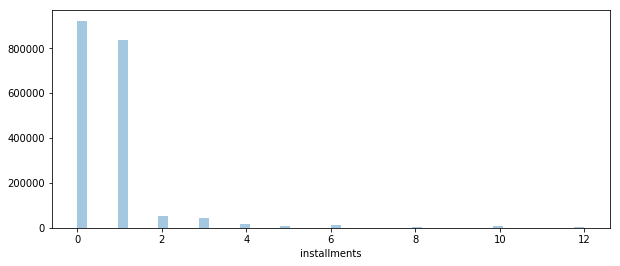

In [215]:
print(new_trans_df['installments'].max())
new_trans_df['installments'] = new_trans_df['installments'].replace(999,np.nan)

# Check the distribution again
plt.figure(figsize=(10,4))
sns.distplot(new_trans_df['installments'].dropna(),kde=False)

This seems like a more reasonable distribution for installments.We see that almost all instalments were either 1 or 0. A few cards however show installment values of -1. These are likely NaNs so we will fill them as such.

In [149]:
new_trans_df['installments'] = new_trans_df['installments'].replace(-1,np.nan)

Now lets take a look at our purchase amount limited to the 0th and 99th percentile.

In [151]:
def upper_bound(series,percent):
    mask = (series<np.percentile(series,percent))
    return series[mask]

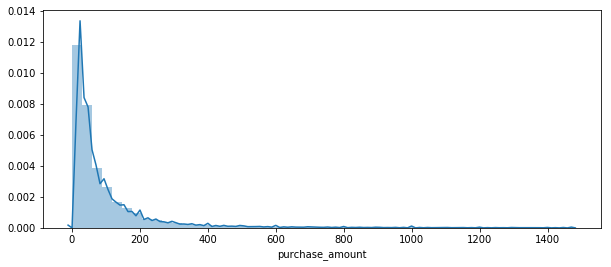

In [214]:
# Now lets check the distribution of our purchase amount
plt.figure(figsize=(10,4))
sns.distplot(upper_bound(new_trans_df['purchase_amount'].dropna(),99))

Purchase amount has a large portion of the data below 0 indicating that it was likely scaled in some way. With some real detective work we can figure this out but thankfully someone else figured it out for us:

https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights

In [153]:
new_trans_df['purchase_amount'] = np.round(new_trans_df['purchase_amount'] / 0.00150265118 + 497.06,2)

#### Categorical Variables

Now that we have a better feel for the distributions of our numeric features we can start to look at our categoric features which make up majority of the columns.

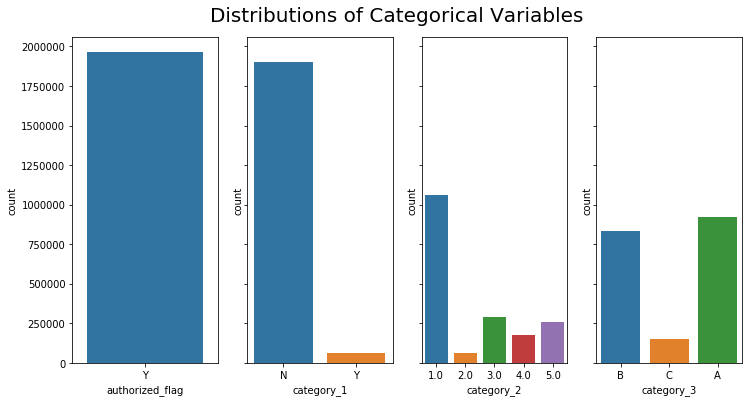

In [154]:
# Excluding ID columns for now
categorical_cols = ['authorized_flag','category_1','category_2','category_3']

f,axes = plt.subplots(1,4,figsize=(12,6),sharey=True)

axes = axes.ravel()
for i,col in enumerate(categorical_cols):
    sns.countplot(new_trans_df[col],ax=axes[i])
plt.suptitle('Distributions of Categorical Variables',
             size=20,
             y=0.95)
plt.show()


Here we see that authorized flag is Y for every value so we can go ahead and drop it. Category 1 is a boolean column that is heavily unbalanced. Category 2 has 5 values with a majority falling into the first category. Category threes frequencies go from A-C so an alphabetical label encoding could preserve some info here. Lets preprocess these categories and look into the ID columns.

In [157]:
new_trans_df['category_1'] = new_trans_df['category_1'].map({'Y':1,'N':0}).astype('bool')
new_trans_df['category_3'],_ = pd.factorize(new_trans_df['category_3'],sort=True)
new_trans_df = new_trans_df.drop(columns='authorized_flag')

IDs by themselves wont tell us much so lets look at how there sizes relate to each other.

In [194]:
number_id_cols = ['city_id','merchant_category_id','state_id','subsector_id']

for col in number_id_cols:
    print(col)
    print('nunique:',len(new_trans_df[col].unique()))
    print('min:',new_trans_df[col].min())
    print('max:',new_trans_df[col].max(),'\n')

city_id
nunique: 308
min: 1.0
max: 347.0 

merchant_category_id
nunique: 314
min: 2.0
max: 891.0 

state_id
nunique: 25
min: 1.0
max: 24.0 

subsector_id
nunique: 41
min: 1.0
max: 41.0 



So it appears that missing ids have been filled with -1 for many of the id columns, lets replace these with NaNs.

In [193]:
for col in number_id_cols:
    new_trans_df[col] = new_trans_df[col].replace(-1,np.nan)

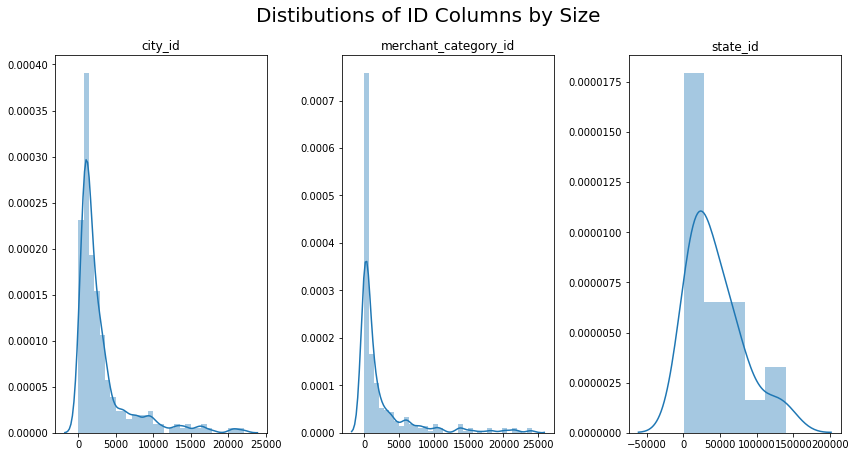

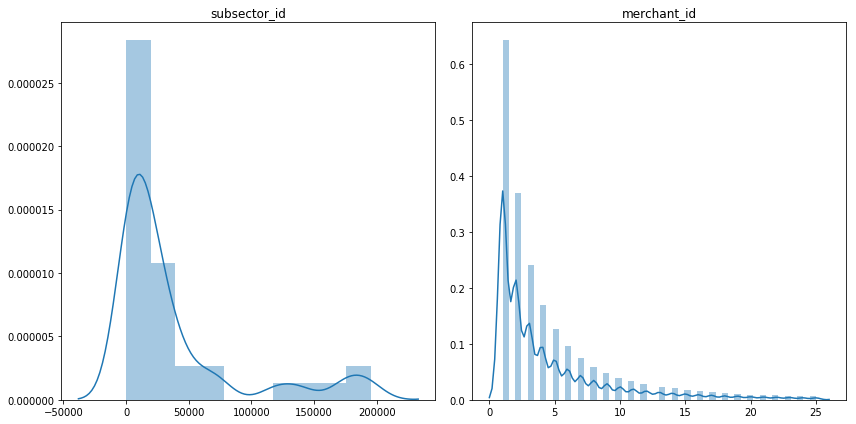

In [195]:
id_cols = number_id_cols+['merchant_id']
f,axes = plt.subplots(1,3,figsize=(12,6))
axes = axes.ravel()

for i,col in enumerate(id_cols[:3]):
    id_size = new_trans_df.groupby([col]).size()
    sns.distplot(upper_bound(id_size,95),ax=axes[i])
    axes[i].set_title(f'{col}')
plt.suptitle('Distibutions of ID Columns by Size',size=20,y=1.05)
plt.tight_layout()
plt.show()

f,axes = plt.subplots(1,2,figsize=(12,6))
axes = axes.ravel() 
for i,col in enumerate(id_cols[3:]):
    id_size = new_trans_df.groupby([col]).size()
    sns.distplot(upper_bound(id_size,95),ax=axes[i])
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

Here we see that most ids have between 0 and 5 counts. Whats interesting to note is the order of the merchant_ids by size which shows near perfect exponential decay.

### Time Features

The final feature to look at is the time when each transaction took place. We can use this to make several different date time features.

In [208]:
new_trans_df.head()

,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,C_ID_415bb3a509,107.0,True,1.0,1,307.0,M_ID_b0c793002c,1,126.00,2018-03-11 14:57:36,1.0,9.0,19.0
1,C_ID_415bb3a509,140.0,True,1.0,1,307.0,M_ID_88920c89e8,1,118.01,2018-03-19 18:53:37,1.0,9.0,19.0
2,C_ID_415bb3a509,330.0,True,1.0,1,507.0,M_ID_ad5237ef6b,2,130.35,2018-04-26 14:08:44,1.0,9.0,14.0
3,C_ID_415bb3a509,NaN,True,1.0,1,661.0,M_ID_9e84cda3b1,1,49.90,2018-03-07 09:43:21,NaN,NaN,8.0
4,C_ID_ef55cf8d4b,NaN,True,1.0,1,166.0,M_ID_3c86fa3831,1,57.90,2018-03-22 21:07:53,NaN,NaN,29.0


In [209]:
# Datetime features
new_trans_df['purchase_date'] = pd.to_datetime(new_trans_df['purchase_date'])
new_trans_df['year'] = new_trans_df['purchase_date'].dt.year.astype('int16')
new_trans_df['month'] = new_trans_df['purchase_date'].dt.month.astype('int16')
new_trans_df['weekofyear'] = new_trans_df['purchase_date'].dt.weekofyear.astype('int16')
new_trans_df['day'] = new_trans_df['purchase_date'].dt.day.astype('int16')
new_trans_df['dayofweek'] = new_trans_df['purchase_date'].dt.dayofweek.astype('int16')
new_trans_df['weekend'] = (new_trans_df.purchase_date.dt.weekday >=5).astype('bool')
new_trans_df['hour'] = new_trans_df['purchase_date'].dt.hour.astype('int16')

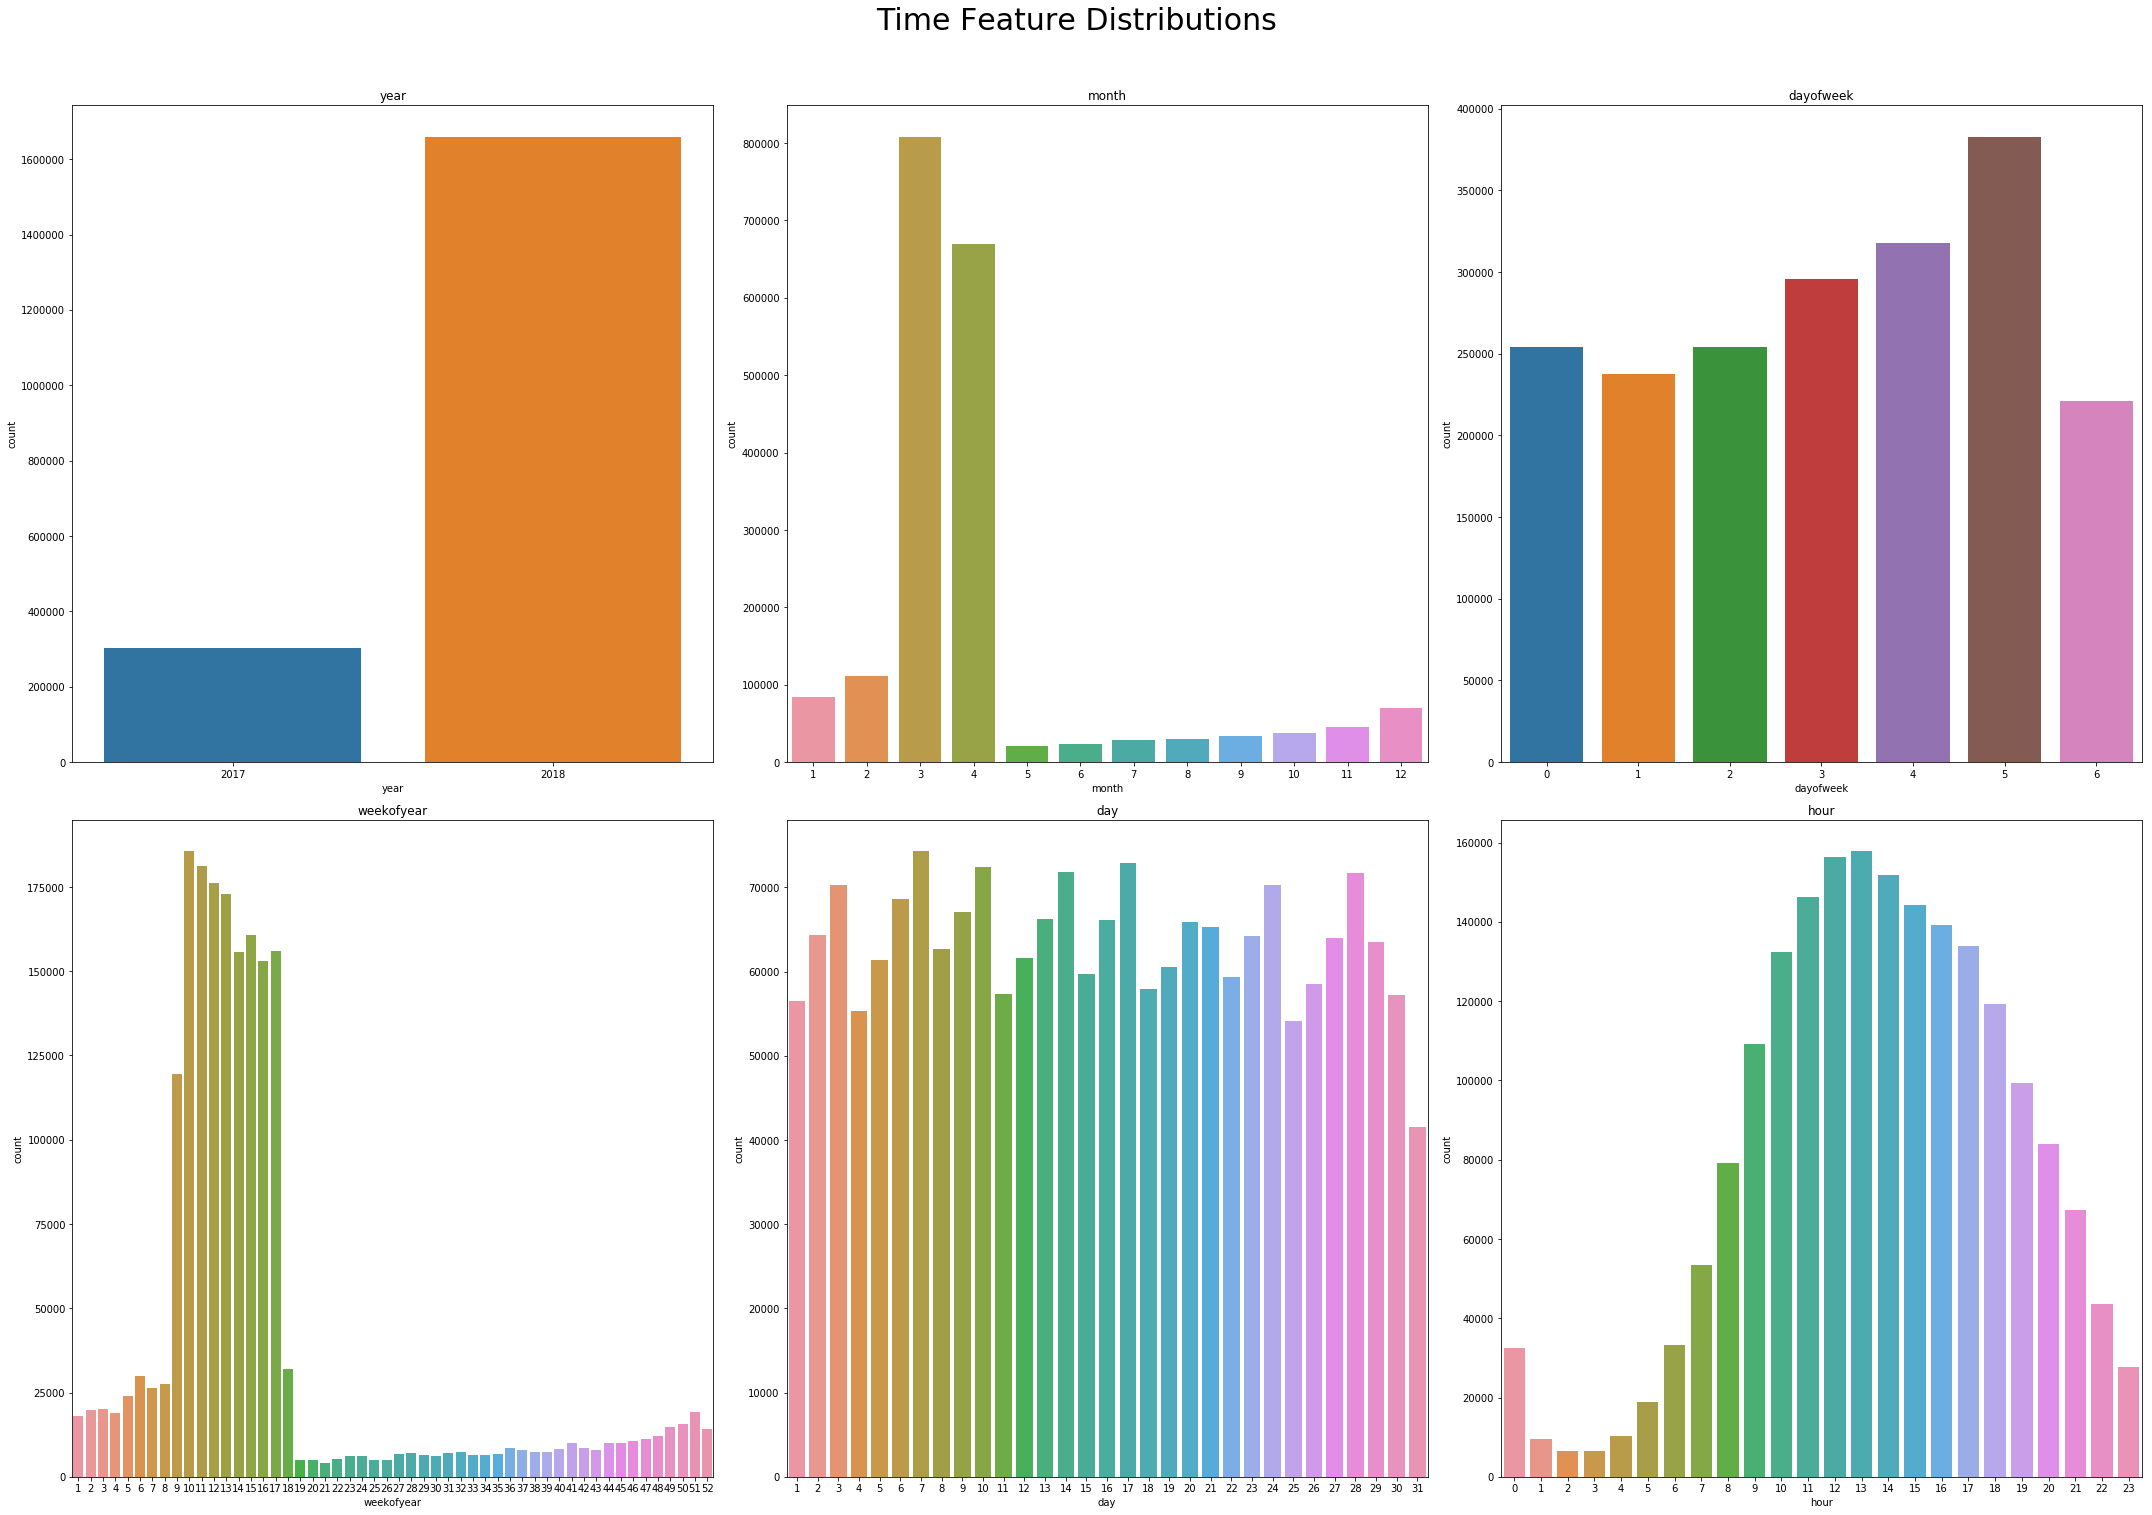

In [222]:
time_cols = ['year','month','dayofweek','weekofyear','day','hour']
f,axes = plt.subplots(2,3,figsize=(30,20))
axes = axes.ravel()

for i,col in enumerate(time_cols):
    sns.countplot(new_trans_df[col],ax = axes[i])
    axes[i].set_title(col)
plt.suptitle('Time Feature Distributions',size = 30, y = 1.05)
plt.tight_layout()

Here we can understand more when our transactions take place. Most of the transactions occured in 2018 the Months 3 and 4 appear to be the most common which seems peculiar as this is not a time we would expect to be particularily busy. When we add the month_lag column we see that these purchases actually correspond to different times. Lets update some of our time features to account for this lag feature.

In [225]:
new_trans_df['month_diff'] = (((datetime.datetime.today()-new_trans_df['purchase_date']).dt.days)//30).astype('int16')
new_trans_df['month_diff'] += new_trans_df['month_lag']

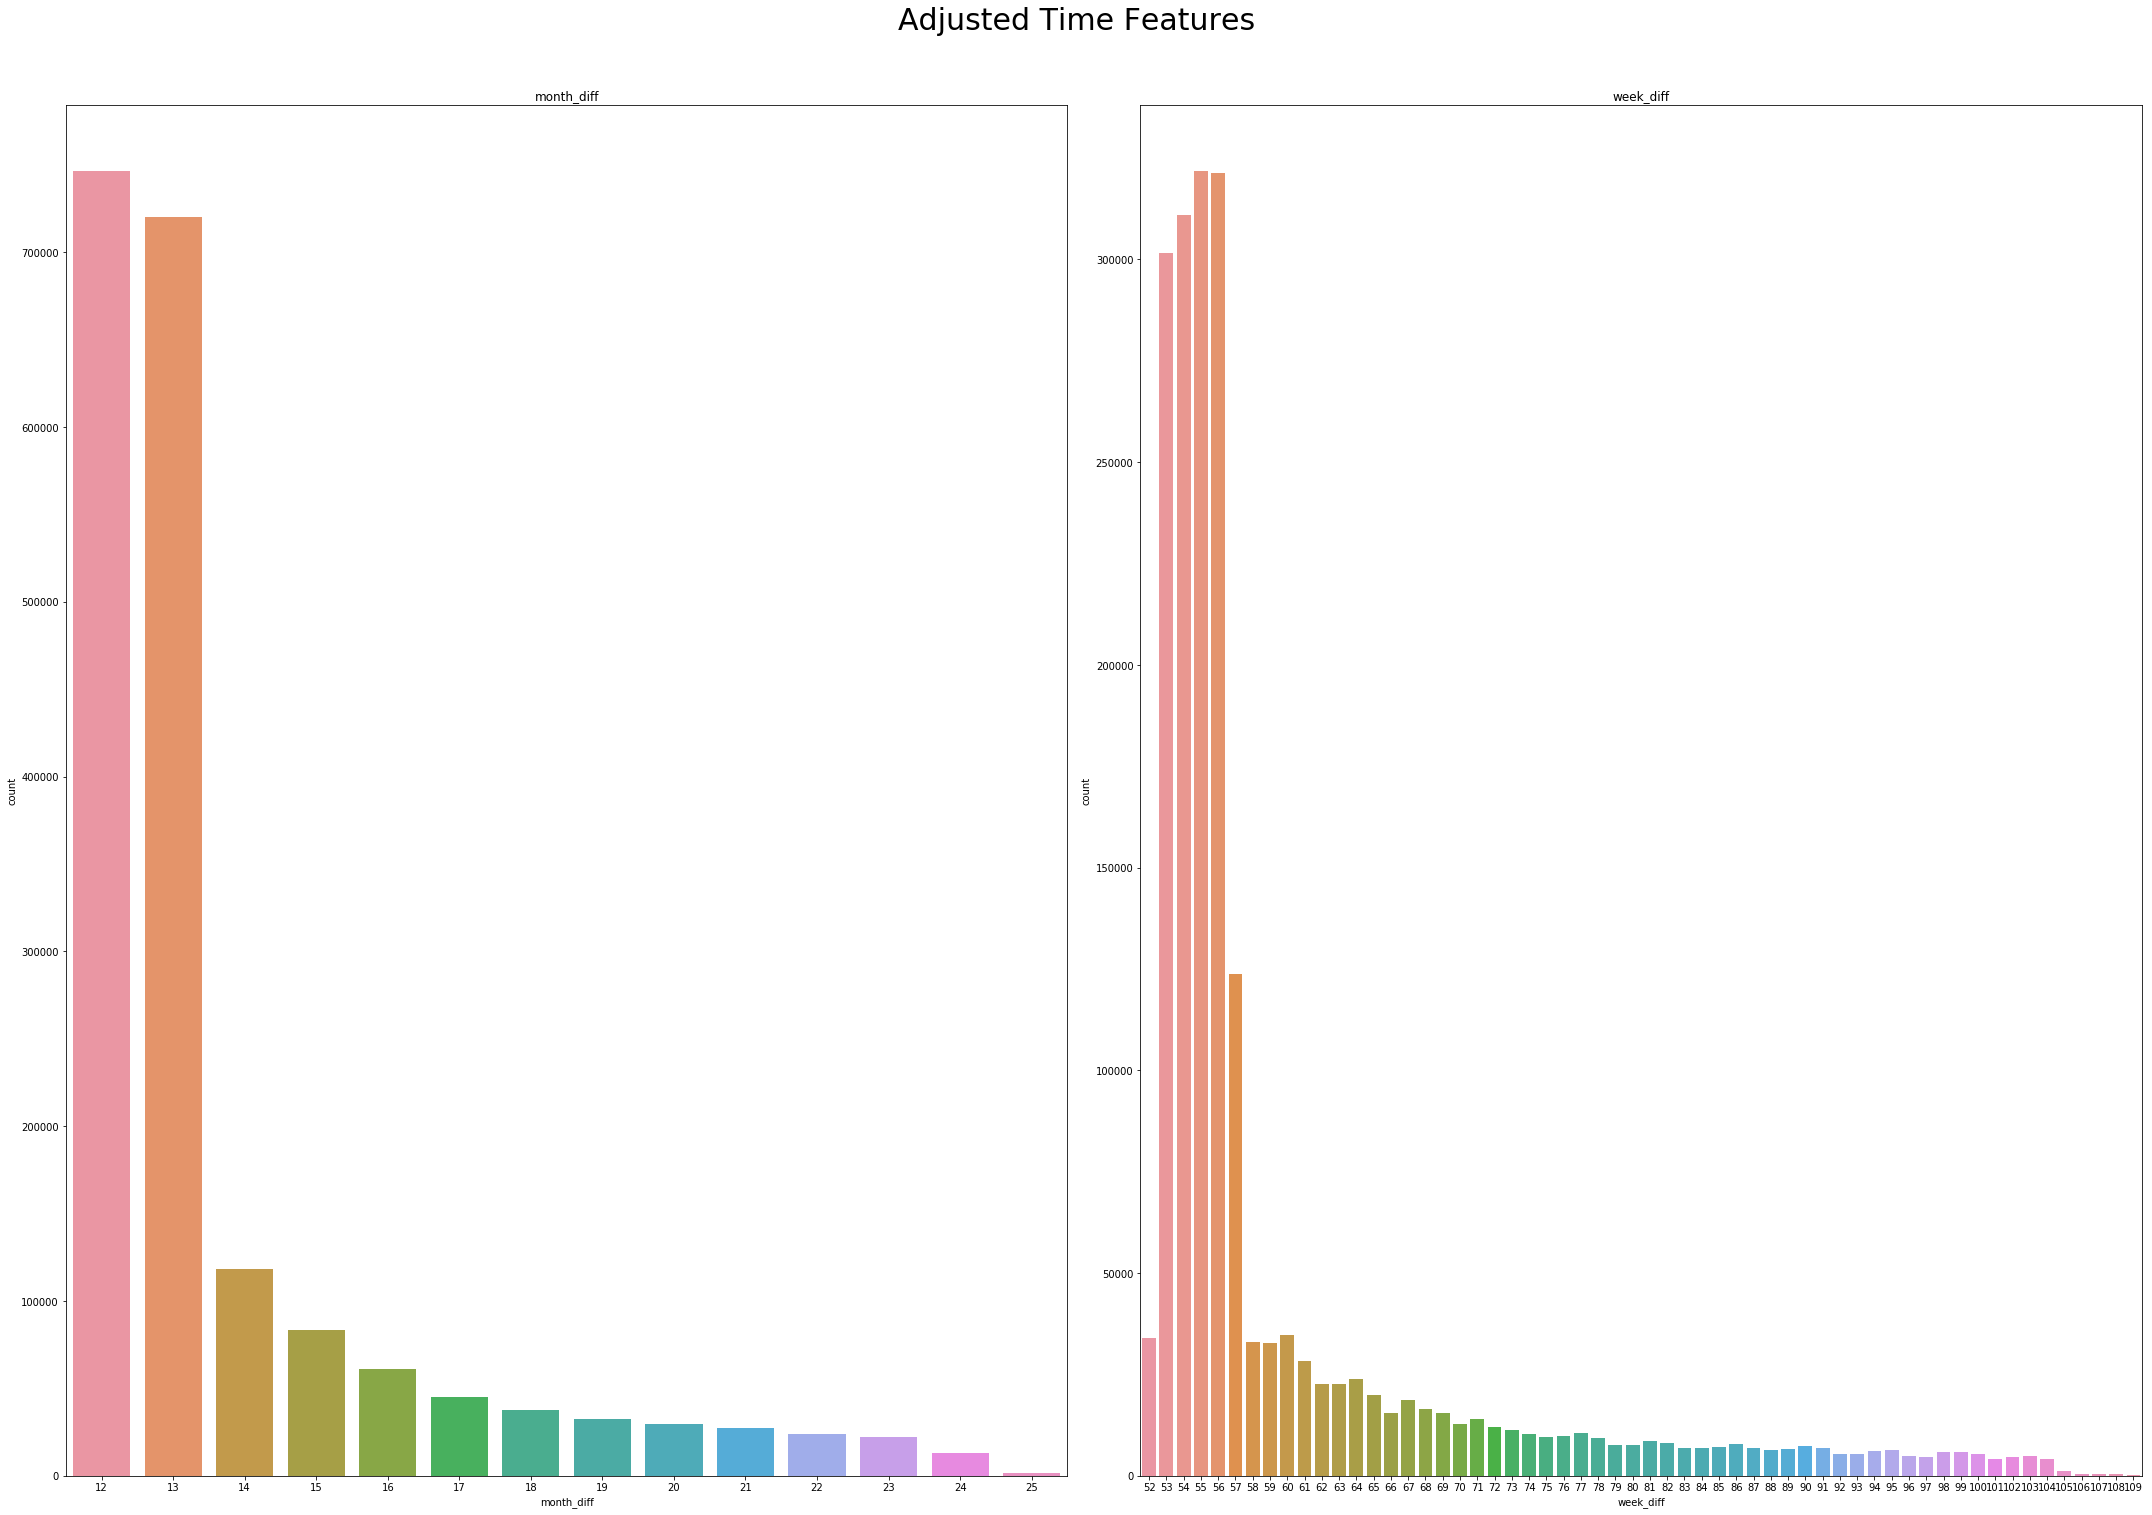

In [226]:
plt.figure(figsize=(8,4))
sns.countplot(new_trans_df['month_diff'])

Two months, specifically during a 4 week stretch make up a vast majority of purchases in the new transactions data frame. Now we can move on to the historical transactions csv file

In [229]:
hist_df = pd.read_csv("historical_transactions.csv",dtype=data_types,parse_dates=True)

In [230]:
hist_df.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


The historical transactions has the same features as the new transactions data frame. We can apply much the same analysis here to understand the features.

### Numeric Features

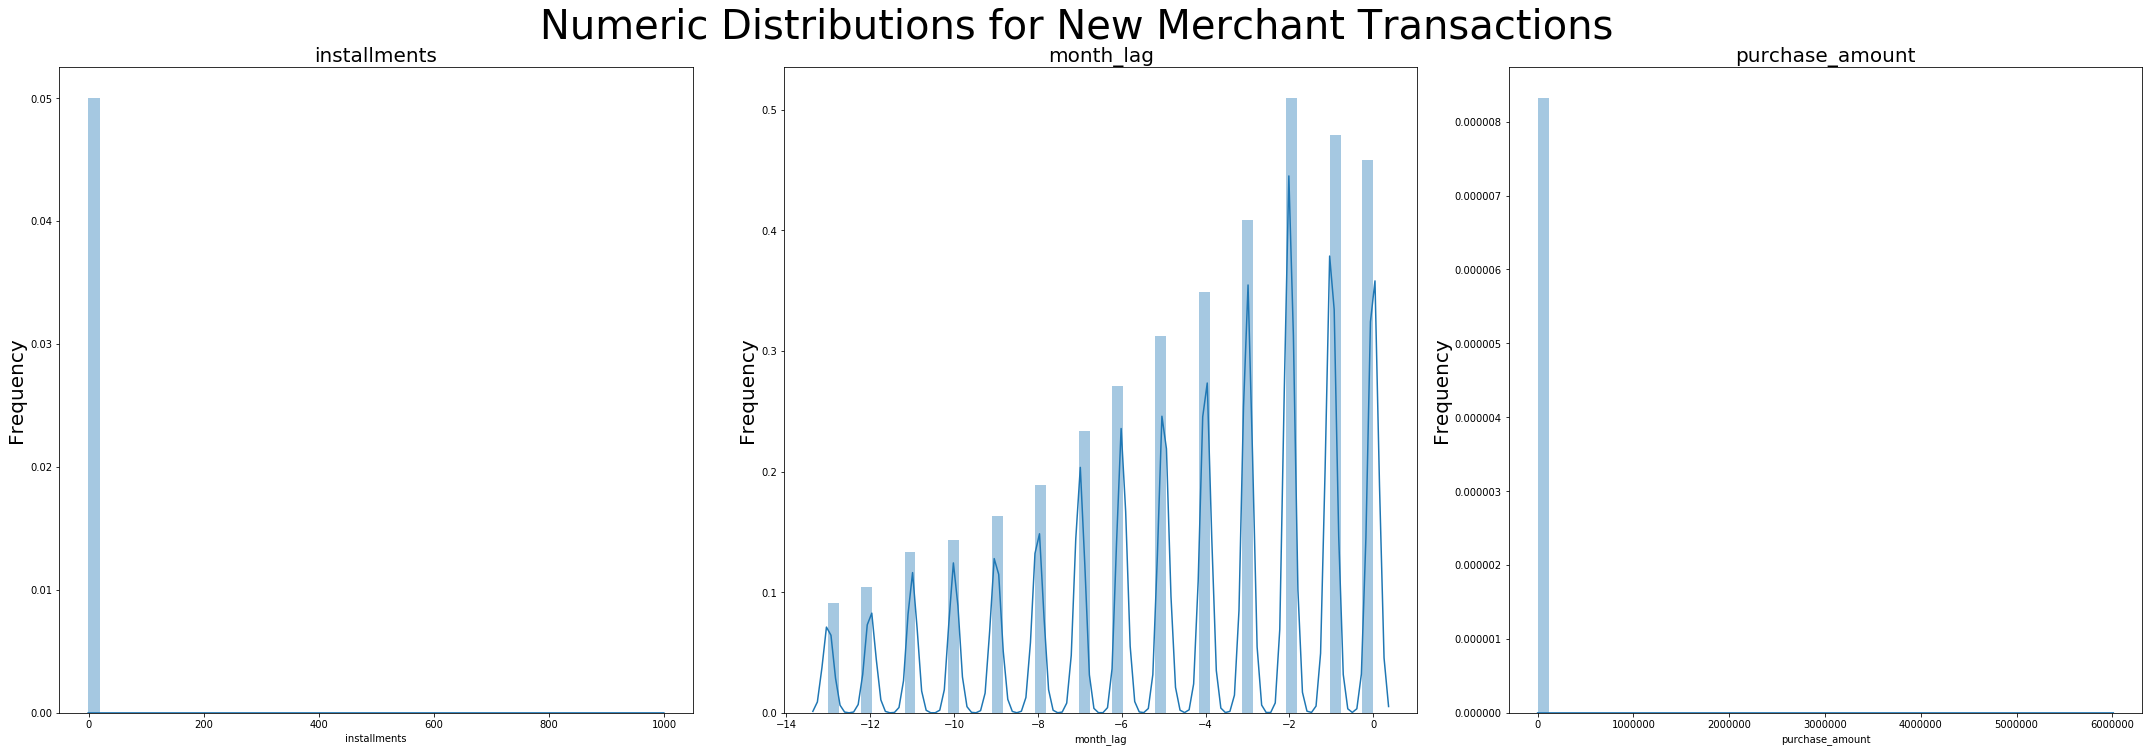

In [231]:
numeric_cols = ['installments','month_lag','purchase_amount']

f,axes = plt.subplots(1,3,figsize=(30,10))
axes = axes.ravel()

for i,col in enumerate(numeric_cols):
    sns.distplot(hist_df[col].dropna(),ax=axes[i],kde=False)
    axes[i].set_title(col,size=20)
    axes[i].set_ylabel('Frequency',size=20)
    axes[i].tick_params(axis='y', labelsize=10)
plt.suptitle("Numeric Distributions for New Merchant Transactions",size=40,y=1.04)
plt.tight_layout()
plt.show()

Installments again seem to have 999 NaN values. Month lag more values and a meaningful distribution. Purchase amount is again skewed and scaled in the same way.

In [ ]:
hist_df['installments'] = hist_df['installments'].replace(-1,np.nan)
hist_df['installments'] = hist_df['installments'].replace(999,np.nan)
hist_df['purchase_amount'] = np.round(hist_df['purchase_amount'] / 0.00150265118 + 497.06,2)

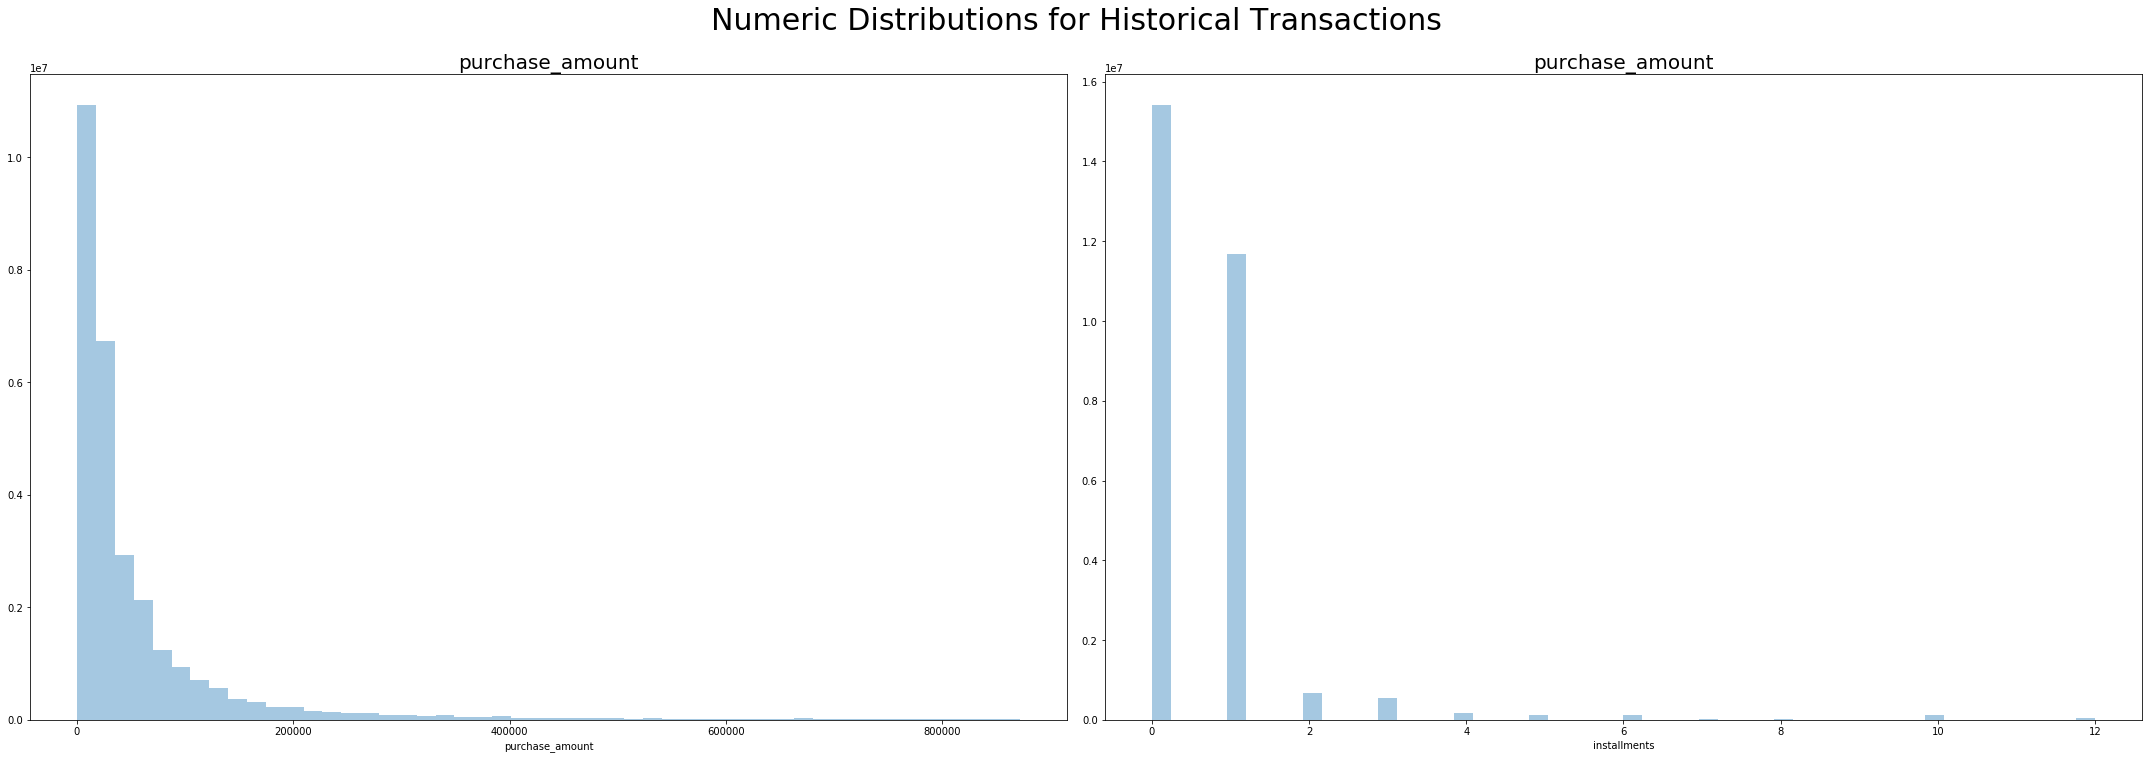

In [236]:
f,axes = plt.subplots(1,2,figsize=(30,10))
axes = axes.ravel()

sns.distplot(upper_bound(hist_df['purchase_amount'].dropna(),99),ax=axes[0],kde=False)
axes[0].set_title(col,size=20)
sns.distplot(hist_df['installments'].dropna(),ax=axes[1],kde=False)
axes[1].set_title(col,size=20)

plt.suptitle("Numeric Distributions for Historical Transactions",size=30,y=1.05)
plt.tight_layout()
plt.show()

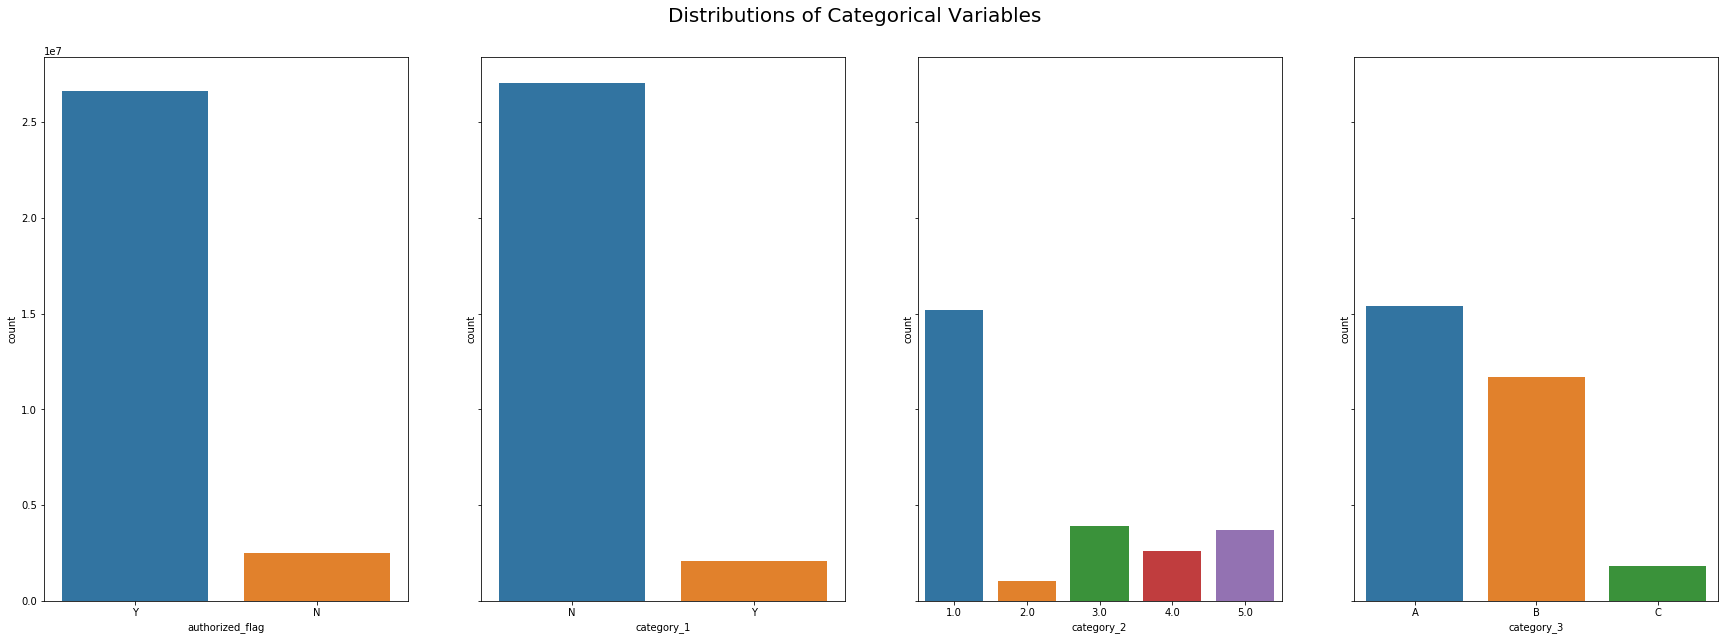

In [239]:
# Excluding ID columns for now
categorical_cols = ['authorized_flag','category_1','category_2','category_3']

f,axes = plt.subplots(1,4,figsize=(30,10),sharey=True)

axes = axes.ravel()
for i,col in enumerate(categorical_cols):
    sns.countplot(hist_df[col],ax=axes[i])
plt.suptitle('Distributions of Categorical Variables',
             size=20,
             y=0.95)
plt.show()

In [242]:
hist_df['authorized_flag'] = hist_df['authorized_flag'].map({'Y':1,'N':0}).astype('bool')
hist_df['category_1'] = hist_df['category_1'].map({'Y':1,'N':0}).astype('bool')
hist_df['category_3'],_ = pd.factorize(hist_df['category_3'],sort=True)

### Id Columns

In [240]:
for col in number_id_cols:
    hist_df[col] = hist_df[col].replace(-1,np.nan)

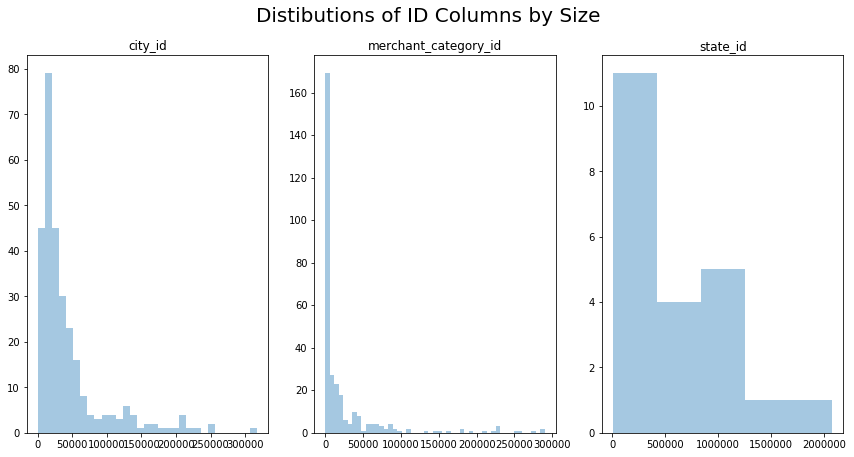

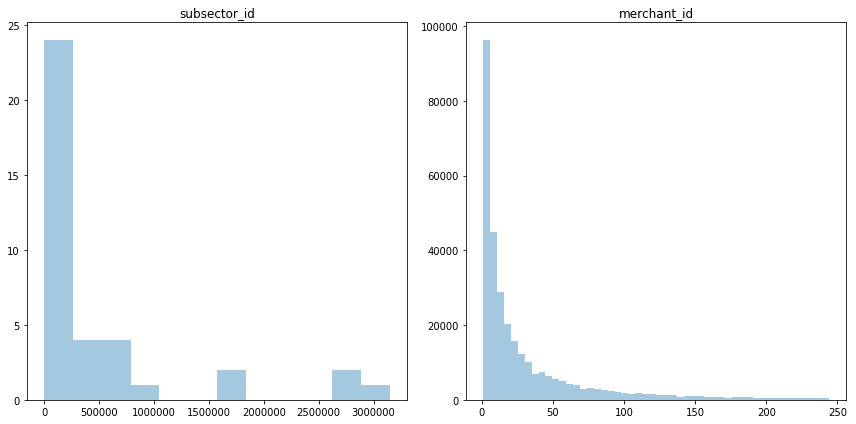

In [244]:
id_cols = number_id_cols+['merchant_id']
f,axes = plt.subplots(1,3,figsize=(12,6))
axes = axes.ravel()

for i,col in enumerate(id_cols[:3]):
    id_size = hist_df.groupby([col]).size()
    sns.distplot(upper_bound(id_size,95),ax=axes[i],kde=False)
    axes[i].set_title(f'{col}')
plt.suptitle('Distibutions of ID Columns by Size',size=20,y=1.05)
plt.tight_layout()
plt.show()

f,axes = plt.subplots(1,2,figsize=(12,6))
axes = axes.ravel() 
for i,col in enumerate(id_cols[3:]):
    id_size = hist_df.groupby([col]).size()
    sns.distplot(upper_bound(id_size,95),ax=axes[i],kde=False)
    axes[i].set_title(f'{col}')
plt.tight_layout()
plt.show()

Again Merchant Id has an exceptionally well ordered distribution. Lets move on to time series features.

### Time Features

In [246]:
# Datetime features
hist_df['purchase_date'] = pd.to_datetime(hist_df['purchase_date'])
hist_df['year'] = hist_df['purchase_date'].dt.year.astype('int16')
hist_df['month'] = hist_df['purchase_date'].dt.month.astype('int16')
hist_df['weekofyear'] = hist_df['purchase_date'].dt.weekofyear.astype('int16')
hist_df['day'] = hist_df['purchase_date'].dt.day.astype('int16')
hist_df['dayofweek'] = hist_df['purchase_date'].dt.dayofweek.astype('int16')
hist_df['weekend'] = (hist_df.purchase_date.dt.weekday >=5).astype('bool')
hist_df['hour'] = hist_df['purchase_date'].dt.hour.astype('int16')

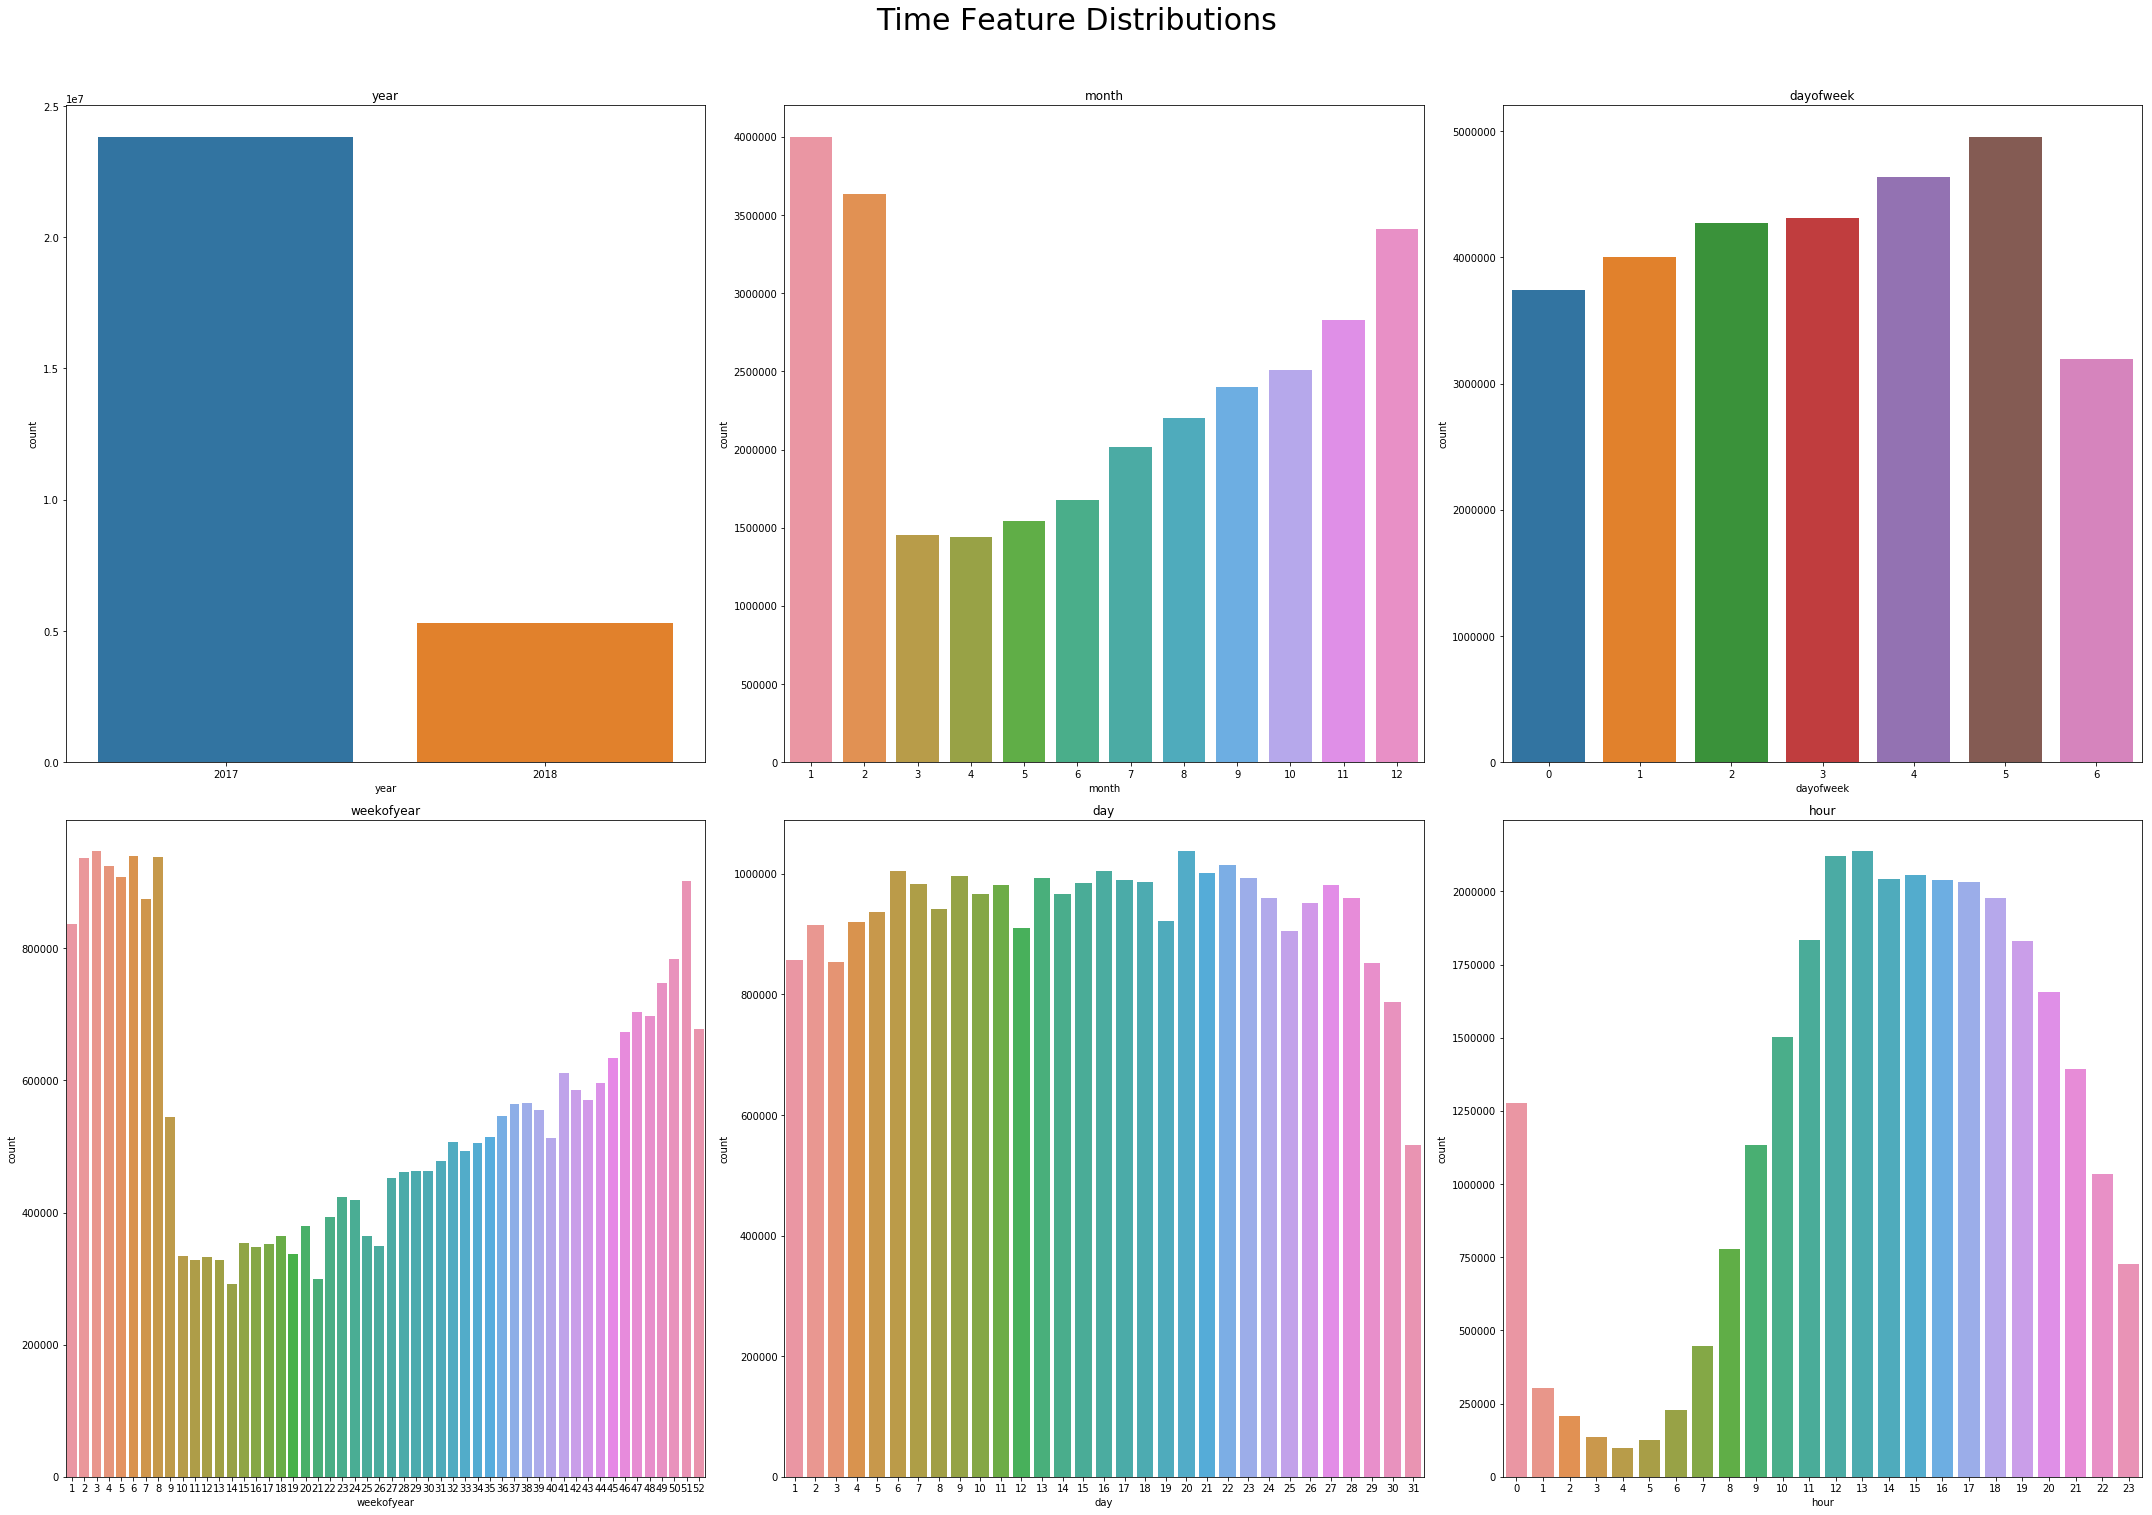

In [247]:
time_cols = ['year','month','dayofweek','weekofyear','day','hour']
f,axes = plt.subplots(2,3,figsize=(30,20))
axes = axes.ravel()

for i,col in enumerate(time_cols):
    sns.countplot(hist_df[col],ax = axes[i])
    axes[i].set_title(col)
plt.suptitle('Time Feature Distributions',size = 30, y = 1.05)
plt.tight_layout()

Looking at these time features we can identify some key differences to the new transactions. Most of the transactions here come from 2017 as opposed to 2018. Most of the transactions occur during the first and second months. Lets again look at how month_lag affects the distributions of these values.

In [248]:
hist_df['month_diff'] = (((datetime.datetime.today()-hist_df['purchase_date']).dt.days)//30).astype('int16')
hist_df['week_diff'] = (((datetime.datetime.today()-hist_df['purchase_date']).dt.days)//7).astype('int16')
hist_df['week_diff'] += hist_df['month_lag']*4
hist_df['month_diff'] += hist_df['month_lag']

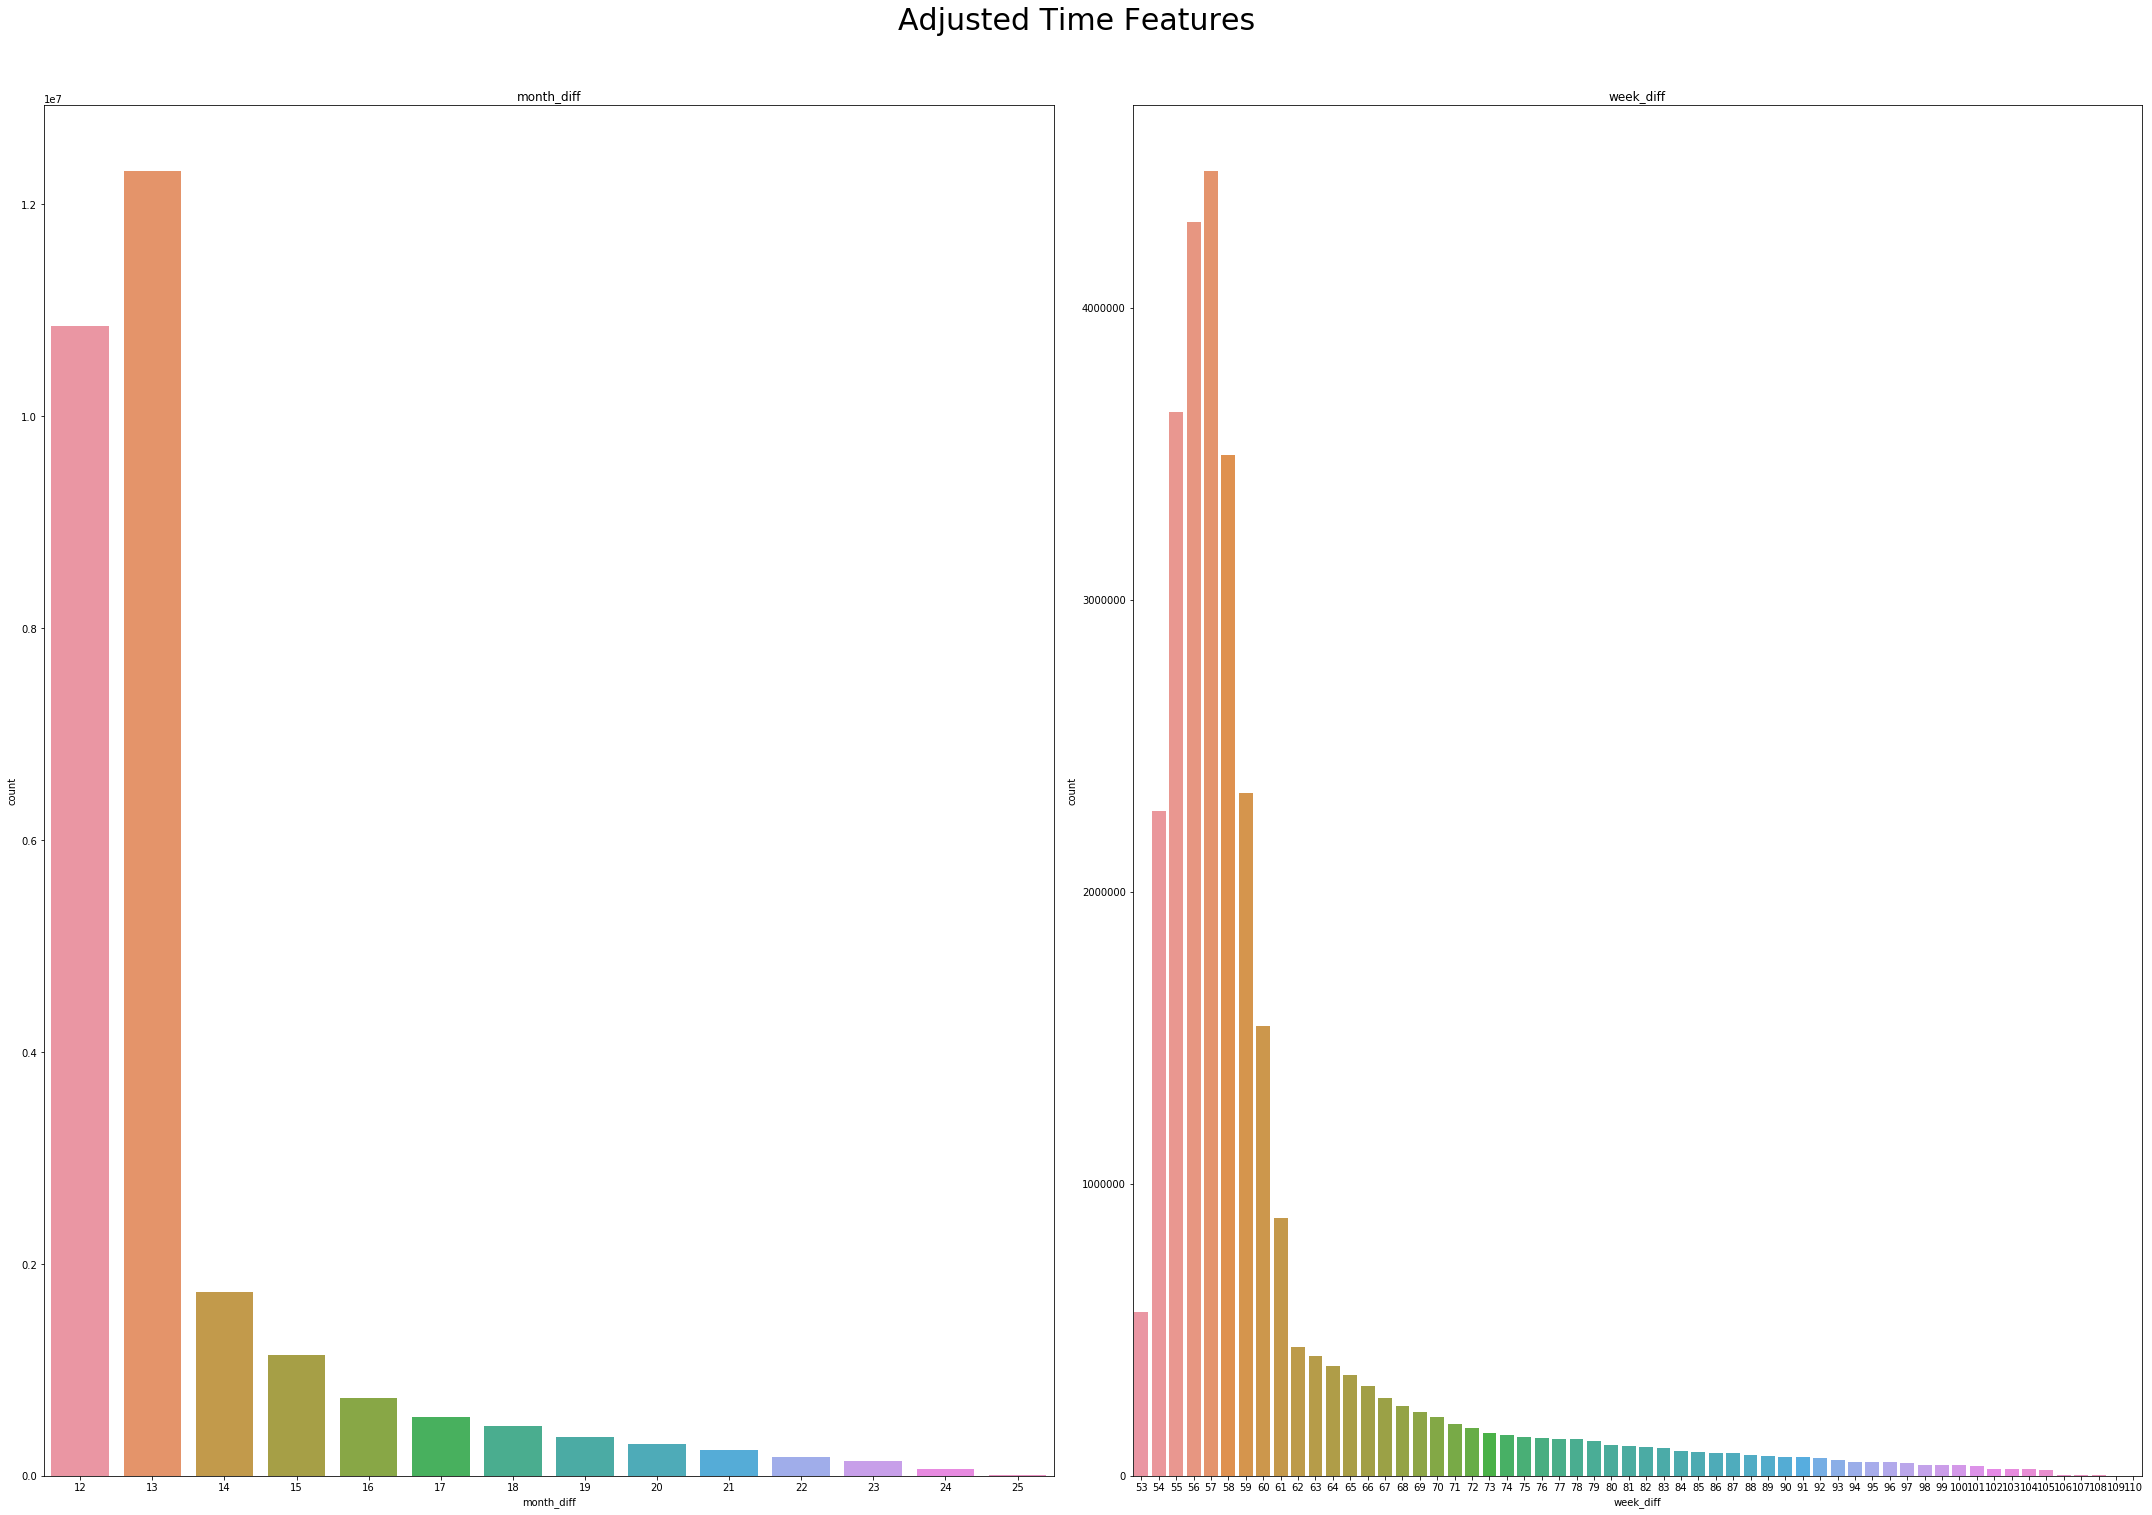

In [249]:
diff_cols = ['month_diff','week_diff']

f,axes = plt.subplots(1,2,figsize=(20,10))
axes = axes.ravel()

for i,col in enumerate(diff_cols):
    sns.countplot(hist_df[col],ax = axes[i])
    axes[i].set_title(col)
plt.suptitle('Adjusted Time Features',size = 30, y = 1.05)
plt.tight_layout()

Adding month lag shows the same pattern we found in the new transactions dataframe. Almost all transactions occured in two months within a 4 week span where transactions spiked dramatically. Now that we have finished some initial EDA we can start to create some features that may be helpful to our model.

---